<a href="https://colab.research.google.com/github/akprodromou/DWS101-Machine-Learning/blob/main/Exercise6/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DWS101
## Exercise 6 - Data Engineering

### Εισαγωγή

Σε αυτή την ανάλυση, ο στόχος μας είναι η εκτίμηση του πιστωτικού κινδύνου για δανειολήπτες μιας τράπεζας. Ως πιστωτικό κίνδυνο ορίζουμε την πιθανότητα ο πελάτης μιας τράπεζας να μην μπορέσει να ανταποκριθεί στην υποχρέωσή του και επομένως, να μην αποπληρώσει το δάνειό του. Σύμφωνα με την [Ευρωπαϊκή Τράπεζα Επενδύσεων](https://www.eib.org/en/publications/20240217-default-and-recovery-statistics-private-and-public-lending-1994-2023#:~:text=Default%20and%20recovery%20rates%20analysis,recovery%20rates%20greater%20than%2090%25.), το ποσοστό μη εξυπηρετούμενων δανείων που χορηγήθηκαν σε ιδιώτες ανέρχεται σε περίπου 3.56% το 2023.

Προκειμένου να μπορέσει η τράπεζα να ελαχιστοποιήσει τον πιστωτικό κίνδυνο θα πρέπει να διαθέτει ένα αποτελεσματικό σύστημα αξιολόγησης των πελατών της. Σε αυτό το project, θα δημιουργήσουμε ένα μοντέλο μηχανικής μάθησης που θα εξυπηρετεί αυτό το σύστημα αξιολόγησης.

Ως δεδομένα χρησιμοποιούμε ένα dataset που δίνεται στο [Kaggle](https://www.kaggle.com/datasets/hetvigandhi03/loan-risk-analysis-dataset-real-world-data), χωρίς να προσδιορίζεται η χώρα ή το χρηματοπιστωτικό ίδρυμα. Δεν μας δίνεται το νόμισμα των ποσών, οπότε θα υποθέσω πως αφορά Ευρώ (€).

### Μεταφόρτωση Βιβλιοθηκών

Θα ξεκινήσουμε εισάγοντας τις βιβλιοθήκες που θα χρησιμοποιήσουμε:

In [442]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# for the heatmap
import seaborn as sns
# data description
!pip install ydata-profiling -q
from ydata_profiling import ProfileReport
# για πράξεις
import random
import math
import re
# για το γράφημα
import plotly.express as px
import plotly.graph_objects as go
# flow chart
!pip install mermaid-py -q
import mermaid as md
from mermaid.graph import Graph
# για την κανονικοποίηση
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
# for training
from sklearn.model_selection import train_test_split
# and predictions
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# assessment
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    f1_score
)
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

## Εισαγωγή δεδομένων

In [443]:
df_raw = pd.read_csv("/content/bankloan.csv")

In [444]:
df_raw.head()

,Row ID,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,...,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Unnamed: 50,36months,60months
0,1.00,60516983,64537751,20000,20000,36 months,12.29,667.06,C,C1,...,INDIVIDUAL,NaN,NaN,0,0,52303,41000,NaN,1.00,0.00
1,2.00,60187139,64163931,11000,11000,36 months,12.69,369.00,C,C2,...,INDIVIDUAL,NaN,NaN,0,332,175731,13100,NaN,1.00,0.00
2,3.00,60356453,64333218,7000,7000,36 months,9.99,225.84,B,B3,...,INDIVIDUAL,NaN,NaN,0,0,202012,16300,NaN,1.00,0.00
3,4.00,59955769,63900496,10000,10000,36 months,10.99,327.34,B,B4,...,INDIVIDUAL,NaN,NaN,0,0,108235,34750,NaN,1.00,0.00
4,5.00,58703693,62544456,9550,9550,36 months,19.99,354.87,E,E4,...,INDIVIDUAL,NaN,NaN,0,0,45492,14100,NaN,1.00,0.00


In [445]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212999 entries, 0 to 212998
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Row ID                       368 non-null     float64
 1   id                           212999 non-null  int64  
 2   member_id                    212999 non-null  int64  
 3   loan_amnt                    212999 non-null  int64  
 4   funded_amnt                  212999 non-null  int64  
 5   term                         212999 non-null  object 
 6   int_rate                     212999 non-null  float64
 7   installment                  212999 non-null  float64
 8   grade                        212999 non-null  object 
 9   sub_grade                    212999 non-null  object 
 10  emp_title                    200209 non-null  object 
 11  emp_length                   200232 non-null  object 
 12  home_ownership               212999 non-null  object 
 13 

In [446]:
profile = ProfileReport(df_raw, title="Profiling Report")
# profile

Βλέπω καταρχήν πως η βάση δεδομένων αφορά άτομα που όλοι έχουν ήδη λάβει δάνειο, εκ των οποίων 210226 το εξυπηρετούν και 2773 έχουν ληξιπρόθεσμο χρέος.

### Ερώτημα 2 - Data Preprocessing & Visualization

Για την προεπεξεργασία των δεδομένων μας θα ακολουθήσουμε την παρακάτω διαδικασία:


In [447]:
process_flowchart = md.Mermaid("""
flowchart LR
    id1[(Database)] -- import --> step1["`Descriptive Statistics
    Missing Values
    Low Variance
    Correlation`"]
    step1 --> step2["`Deduplication
    Outliers`"]
    step2 --> featureTransformation[Feature Transformation]
    featureTransformation --> dataTypes[Data Types]
    dataTypes --> step3["`Target Selection
    Data Leakage`"]
    step3 --> modelSelection{Model Selection}
""")

process_flowchart

Θέτουμε τις παραμέτρους των οπτικοποιήσεων:

In [448]:
px.defaults.template = "plotly_white"
color_palette = ['#8c4053', '#40798C','#a170a9', '#70A9A1']
plt.rcParams["font.family"] = "sans-serif"
plt.style.use('fivethirtyeight')

#### Περιγραφικά Στατιστικά

Σε αυτή την ενότητα θα εξετάσουμε ένα - ένα τα χαρακτηριστικά ώστε αφενός να καταλάβουμε τι περιγράφει το καθένα, να τα εξετάσουμε ως προς την πληρότητά τους για τυχόν ελλείπουσες τιμές και τα περιγραφικά στατιστικά τους μέτρα (π.χ. μέση τιμή, διακύμανση και κατανομή).

Από τη βιβλιογραφία, βρίσκουμε πως τα [ορισμένα από τα βασικά - και σημαντικότερα - κριτήρια δανειοδότησης](https://dspace.lib.uom.gr/bitstream/2159/19647/3/ChasapiEleniMsc2016.pdf) είναι τα παρακάτω:

**1. Το ατομικό ή οικογενειακό εισόδημα του δανειολήπτη**

Στην [data card](https://www.kaggle.com/datasets/hetvigandhi03/loan-risk-analysis-dataset-real-world-data) δίνεται από τα:

`annual_inc`: δίνεται χωρίς ελλείπουσες στο dataset, επομένως είναι σημαντικό να το κρατήσω.

`annual_inc_joint`: Αναφέρεται στο συνολικό εισόδημα για τις περιπτώσεις αιτήσεων για δάνειο από κοινού. Δίνεται για μόλις 0.20% των δεδομένων, ενώ για τις υπόλοιπες δίνεται ως «na». Ωστόσο, καθώς το υπόλοιπο 99.80% μπορεί απλώς να αφορά ατομικές αιτήσεις για δάνεια, δεν θα το πετάξω αλλά θα θα το συνδυάσω με το `annual_inc` σε ένα ενιαίο χαρακτηριστικό που θα ονομάσω `total_income`:

In [449]:
df_raw['total_income'] = np.where(df_raw['annual_inc_joint'].isna(), df_raw['annual_inc'], df_raw['annual_inc_joint'])

Σε αυτό θα προσθέσω και μια στήλη για να γνωρίζουμε πότε έχουμε να κάνουμε με joint income ή όχι:

In [450]:
df_raw["is_joint"] = df_raw["annual_inc_joint"].notna().astype(int)

`verification_status`: δίνεται πλήρες, με τις εξής 3 διακριτές τιμές:

Source Verified: 41.4%

Verified: 30.0%

Not Verified: 28.6%

**2. Οι λοιπές υποχρεώσεις και το κόστος διαβίωσης του δανειολήπτη**

`dti` (Debt-to-Income Ratio): Δείχνει το ποσό από το μηνιαίο εισόδημα του ατόμου πηγαίνει στην εξυπηρέτηση των μηνιαίων υποχρεώσεών του (δάνεια, κάρτες, κλπ.). Δίνεται πλήρες στο dataset, με τιμές που έχουν αναχθεί επί τις 100.

`open_acc` (Number of active credit lines): Ο αριθμός των πιστωτικών ορίων (δάνεια, πιστωτικές κάρτες) του δανειολήπτη που είναι ενεργά αυτή τη στιγμή. Δίνεται πλήρες με μέσο όρο 12 και το κρατώ. Έχει πολύ υψηλή συσχέτιση με το `total_acc` (Total credit lines, που) είναι ο συνολικός αριθμός όλων των πιστωτικών λογαριασμών που είχε ποτέ ο δανειολήπτης, με μ.ο. 25.3. Θα κρατήσω το `open_acc` επειδή μου δίνει μια καλύτερη εικόνα για τη σημερινή κατάσταση του υποψήφιου δανειολήπτη.

`revol_bal` (Revolving credit balance) είναι το	Υπόλοιπο Ανακυκολύμενης Πίστωσης, δηλαδή το τρέχον ανεξόφλητο χρηματικό υπόλοιπο στις πιστωτικές κάρτες και τις πιστωτικές γραμμές του ατόμου. Δίνεται πλήρες, με μέση τιμή 17988.0€ και το κρατώ.

`revol_util` (Credit utilization)	είναι το ποσοστό (%) του διαθέσιμου πιστωτικού ορίου που έχει χρησιμοποιηθεί. Έχει μέση τιμή 53% και δεν έχει ελλείπουσες τιμές - θα το κρατήσω. Σε ορισμένες περιπτώσεις ξεπερνάται το 100%, όμως η υπέρβαση του ορίου είναι εφικτή στην πράξη (ορισμένα πιστωτικά ιδρύματα το επιτρέπουν), οπότε δεν θα επέμβω σε αυτές τις τιμές.

`inq_last_6mths` (Loan inquiries)	είναι ο αριθμός των φορών που ο δανειολήπτης ρώτησε ή αιτήθηκε για νέο δάνειο/πίστωση τους τελευταίους 6 μήνες, με ελάχιστο το 0 και μέγιστο το 5.

`dti_joint` είναι το debt-to-income ratio που είδαμε παραπάνω, αλλά για τις περιπτώσεις δανείων από κοινού (joint loans). Όμοια με το `annual_inc_joint`, δίνεται μόλις για το 0.20% των δανειολήπτης, αλλά κι εδώ θα κάνω μια νέα στήλη ώστε να λαμβάνεται υπόψιν όταν `is_joint` είναι ίσο με 1 (True):

In [451]:
df_raw['total_dti'] = np.where(df_raw['dti_joint'].isna(), df_raw['dti'], df_raw['dti_joint'])

`acc_now_delinq`: είναι ο αριθμός των λογαριασμών όπου ο δανειολήπτης έχει τρέχουσα καθυστέρηση πληρωμής. Κυμαίνεται μεταξύ 0 και 5, δεν έχει ελλείπουσες και θα το κρατήσω.

`tot_coll_amt`: Το συνολικό χρηματικό ποσό (collection amount) σε λογαριασμούς του δανειολήπτη που έχει είτε καταλήξει σε εισπρακτικές προς είσπραξη είτε έχει θεωρηθεί μη-εισπράξιμο. Από το report βλέπω πως είναι 0 για το 84% των περιπτώσεων και φτάνει έως τις 380.000.

`tot_cur_bal`: Το συνολικό τρέχον ανεξόφλητο υπόλοιπο σε όλους τους λογαριασμούς, κυμαίνεται από 0 έως και €4.12 εκ.

`total_rev_hi_lim`: Το συνολικό διαθέσιμο πιστωτικό όριο του ατόμου σε όλες τις πιστωτικές κάρτες και πιστωτικές γραμμές. Κυμαίνεται από 0 έως και €1.64 εκ.

**3. Οι παρεχόμενες εξασφαλίσεις**

Αυτές αφορούν είτε ενοχικές εξασφαλίσεις (προσωπικές εγγυήσεις) από τρίτα πρόσωπα, είτε εμπραγμάτες εξασφαλίσεις (π.χ. προσημείωση υποθήκης, παρακράτηση κυριότητας). Στα συγκεκριμένα δεδομένα δεν υπάρχει κάποιο χαρακτηριστικό με στοιχεία collateral, mortgage ή guarantees που να τις καλύπτει ως αντικείμενο.

**4. Η φερεγγυότητα του υποψήφιου δανειολήπτη που μπορεί να ελεγχθεί με βάση τις προηγούμενες πιστοληπτικές σχέσεις του πελάτη με την τράπεζα και με άλλες τράπεζες**

`grade`: Δίνεται ένα grade score από προηγούμενες συναλλαγές, με διακριτές τιμές από A έως G, χωρίς ελλείπουσες τιμές. Ας δούμε την κατανομή του:



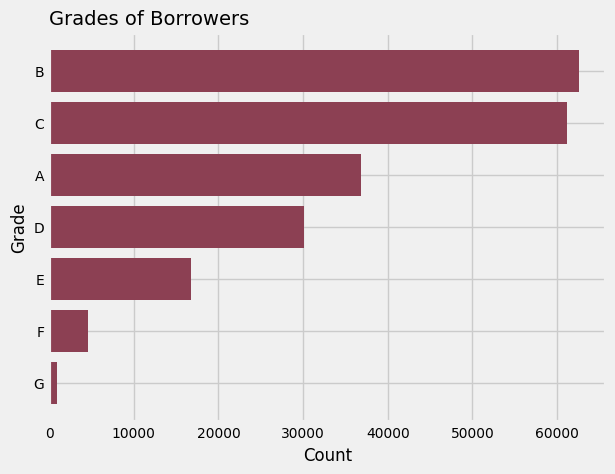

In [452]:
grad_counts = df_raw['grade'].value_counts(normalize=False, sort=True, ascending=True, bins=None, dropna=True)

fig, ax = plt.subplots()

labels = grad_counts.index
values = grad_counts.values

plt.barh(labels, values, color = color_palette[0])

plt.title('Grades of Borrowers', fontsize = 14, loc='left')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Grade', fontsize = 12)
plt.show()


Στην [βιβλιογραφία](https://www.investopedia.com/terms/l/loan-grading.asp) διαβάζουμε πως το κάθε πιστωτικό ίδρυμα έχει σύστημα αξιολόγησης που βαζίζεται στα δικά του κριτήρια. Μικρότερα πιστωτικά ιδρύματα συνηθίζουν να έχουν μια ομάδα «ειδικών» που αποφαίνονται για κάθε περίπτωση, ενώ μεγαλύτεροι οργανισμοί έχουν ένα σύστημα ποσοτικής αξιολόγησης - το οποίο προσπαθούμε να προσδιορίσουμε σε αυτό το project.


`sub_grade`: υποκατηγορίες του `grade`, κυμαινόμενες από 1 έως 5 (π.χ. B3), άρα 35 επί συνόλω.

`delinq_2yrs`: οι καθυστερήσεις πληρωμής του υποψηφίου τα τελευταία 2 χρόνια. Έχει μέση τιμή 0.34 και κυμαίνεται από 0 έως ~15 με ορισμένες ακραίες τιμές να φτάνουν έως το 30.

`earliest_cr_line`: οι ημερομηνίες των πρώτων πιστώσεων που έχουν δοθεί στον υποψήφιο δανειολήπτη. Παρατηρούμε πως έχουμε τα εξής προβλήματα: α) δίνονται ως strings (π.χ. 'May-98') και β) και κυριότερο, άλλοτε δίνονται με το έτος τους (π.χ. 'May-98') και άλλοτε ως ημερομηνία και μήνας ('3-Mar'), με μοιρασμένη αναλογία. Επομένως η στήλη δεν μου παρέχει αξιόπιστη πληροφορία και δεν θα την κρατήσω.

`mths_since_last_delinq`: Είναι οι μήνες που έχουν περάσει από την τελευταία αθετημένη πληρωμή. Από το report βλέπω πως δεν έχει τιμή για το 48.5% των περιπτώσεων, αυτό όμως είναι απαραίτητα λάθος - λογικά σημαίνει πως δεν έχουν χάσει κάποια πληρωμή. Επειδή το να έχει κάποιος πρόσφατη αθετημένη πληρωμή είναι αρνητικό σημάδι, στα 'na' θα δώσω μια μεγάλη τιμή, εν προκειμένω τη μέγιστη από τις δοθείσες (max), προσθέτοντας 5 έτη, ώστε να υπάρχει διάκριση έναντι των περιπτώσεων με αθετημένη πληρωμή:

In [453]:
df_raw['mths_since_last_delinq'] = np.where(df_raw['mths_since_last_delinq'].isna(), df_raw['mths_since_last_delinq'].max() + random.randint(1, 60), df_raw['mths_since_last_delinq'])

`mths_since_last_major_derog`: Όμοια με παραπάνω, και αυτό το χαρακτηριστικό έχει τιμές 'na' όταν δεν υπάρχει καθυστέρηση πληρωμής, επομένως ας το διορθώσω:

In [454]:
df_raw['mths_since_last_major_derog'] = np.where(df_raw['mths_since_last_major_derog'].isna(), df_raw['mths_since_last_major_derog'].max() + random.randint(1, 60), df_raw['mths_since_last_major_derog'])

`pub_rec`: Το χαρακτηριστικό αυτό αφορά δημόσιες καταγραφές οικονομικών υποχρεώσεων που αθετήθηκαν. Από το ιστόγραμμα βλέπω πως έχει τιμή 0 για το 82.3% των περιπτώσεων.

**5. Το ποσό της δόσης για υφιστάμενα δάνεια (αν υπάρχουν)**

Δίνονται εμμέσως από το `dti`, το οποίο καλύψαμε ήδη.

**6. Τυχόν ασυνέπειες του δανειολήπτη στο παρελθόν**

Τα χαρακτηριστικά που εμπίπτουν σε αυτή την κατηγορία και δεν καλύφθηκαν ήδη είναι:

`collections_12_mths_ex_med`: αφορά τον αριθμό των ληξιπρόθεσμων οφειλών των τελευταίων 12 μηνών, εξαιρουμένων οφειλών για ιατρικούς σκοπούς. Κυμαίνεται από 0 έως 7, χωρίς ελλείπουσες.

`acc_now_delinq`: οι αριθμοί των λογαριασμών στους οποίους υπάρχει καθυστέρηση πληρωμών. Είναι διακριτή μεταβλητή που παίρνει τιμές 0 έως 5, χωρίς ελλείπουσες.

`recoveries`: Είναι οι συνολικές ενέργειες που έχουν γίνει για την είσπραξη οφειλών. Φαίνεται πως έχει γίνει λάθος στην καταγραφή αυτού του χαρακτηριστικού, καθώς στο 0.1% των περιπτώσεων για τις οποίες η τιμή είναι > 0, αυτή δίνεται σε χιλιάδες, που δεν έχει λογική. Επομένως το αφαιρώ.

`collection_recovery_fee`: είναι το ποσό που συγκεντρώθηκε από τις προαναφερθείσες ενέργειες. Έχει τιμή 0 για το 99.9% των περιπτώσεων, με μέγιστο το 2037, χωρίς ελλείπουσες. Με δεδομένη την αφαίρεση του `recoveries`, θα το κρατήσω.

**7. Το χρονικό διάστημα για το οποίο εργάζεται στην ίδια θέση**

`emp_length`: Η διάρκεια απασχόλησης. Θέλω να το μετατρέψω σε ακέραιο από string που δίνεται (π.χ. '8 years'), οπότε θα χρησιμοποιήσω regular expressions:

In [455]:
# από κάθε καταγραφή πάρε 1 ή και παραπάνω ψηφία
df_raw['emp_length'] = df_raw['emp_length'].str.extract(r'(\d+)', expand=False).fillna(0).astype(int)

In [456]:
# έλεγχος
df_raw['emp_length'].unique()

array([ 1,  7,  6, 10,  0,  8,  9,  3,  4,  2,  5])

`emp_title`: από το report βλέπω πως έχω 15471 διαφορετικές τιμές για τα επαγγέλματα των δανειοληπτών, αριθμός πολύ μεγάλος για να τις αξιοποιήσω όλες. Βλέπω όμως από το word cloud του report πως οι 10 συνηθέστερες τιμές είναι:

| Value | Count | Frequency (%) |
| :--- | :--- | :--- |
| manager | 32619 | 8.2% |
| director | 8804 | 2.2% |
| sales | 7595 | 1.9% |
| assistant | 7451 | 1.9% |
| teacher | 6045 | 1.5% |
| supervisor | 6039 | 1.5% |
| engineer | 5898 | 1.5% |
| analyst | 5875 | 1.5% |
| specialist | 5868 | 1.5% |
| senior | 5797 | 1.5% |

Αφαιρώ τα 'assistant', 'sales' και 'senior' που μπορούν να εμπίπτουν και σε άλλες κατηγορίες (π.χ. assistant manager) και προσθέτω αντί αυτών τα 'driver', 'technician' και 'officer' που ακολουθούν στη λίστα συχνοτήτων. Θα περάσω αυτά τα επαγγέλματα (καλύπτουν περίπου το 22% όλων των επαγγελμάτων) σε μια νέα στήλη, με τα υπόλοιπα να έχουν την τιμή 'other'. Με τη μέθοδο αυτή δεν θα χάσω όλη την πληροφορία που περιέχει το χαρακτηριστικό:

In [457]:
# κανονικοποιώ τους τίτλους (π.χ. πεζά)
df_raw['emp_title_clean'] = df_raw['emp_title'].str.lower().str.strip()

# η λίστα των επαγγελμάτων
top10_jobs = [
    'manager',
    'director',
    'teacher',
    'supervisor',
    'engineer',
    'analyst',
    'specialist',
    'driver',
    'technician',
    'officer'
]

In [458]:
# Συνάρτηση που μετατρέπει τους 15471 τίτλους επαγγέλματος
# σε 10 σημαντικότερους, που αντιπροσωπέυουν το 23% του συνόλου
def top10_replacements(job_title):
    # αν είναι 'na' επέστρεψε 'other'
    if pd.isna(job_title):
        return "other"
    # αν ένας από τους τίτλους περιέχεται στο υπό εξέταση row
    for job in top10_jobs:
        if job in job_title:
            return job
    return "other"

df_raw['emp_category'] = df_raw['emp_title_clean'].apply(top10_replacements)

**8. Η διαμονή του δανειολήπτη σε ιδιόκτητη ή ενοικιαζόμενη κατοικία**

`home_ownership`: παίρνει τέσσερις τιμές: mortgage (49.8%), rent (39.2%), own (11.1%), any(<0.1%) και δεν έχει ελλείπουσες τιμές.

#### Έλεγχος Ελλειπουσών Τιμών

Από το report βλέπω πως:

- Ελλείπουσες > 80%: `Row ID` (αφαιρέθηκε ήδη), `annual_inc_joint`, `dti_joint`, `36months`, `60months`

`annual_inc_joint`: Έχει ήδη συνδυαστεί με το `annual_inc` σε ένα νέι χαρακτηριστικό `total_income` και αφαιρεθεί.

`dti_joint`: Ομοίως και αυτό.

`36months`: δεν δίνεται στην αρχική data card. Ψάχνοντας τους τύπους των δανείων βλέπουμε πως δίνονται σε επιλογές από 6 έως 60 μήνες. Άρα το συγκεκριμένο χαρακτηριστικό προκύπτει από one-hot encoding του `term`, καθώς παίρνει τιμες 0 ή 1. Έχει μόλις 511 τιμές, άρα είναι ελλειπές και θα το αφαιρέσω. Θα προχωρήσω σε one-hot encoding του `term` παρακάτω.

`60months`: όμοια με το προαναφερθέν.

- Ελλείπουσες > 60%: 'mths_since_last_major_derog'
- Ελλείπουσες > 40%: 'mths_since_last_delinq'

Οι `mths_since_last_major_derog` και `mths_since_last_delinq` έχουν πολλές ελλείπουσες, είναι όμως σημαντικές, καθώς μας λένε εάν υπήρξαν πρόσφατα παραπτώματα σχετικά με τον δανεισμό από τους αιτούντες. Μπορεί να είναι ενδείξεις σπάνιου όμως καθοριστικού γεγονόντος, και άρα να είναι πολύ χρήσιμες στην προβλεψιμότητα του μοντέλου. Θα τις κρατήσω.

Παρατηρώ πως έχω δύο ελλείπουσες τιμές στο `revol_util`, που είναι το ποσό της πίστωσης που χρησιμοποιεί ο δανειολήπτης σε σχέση με το σύνολο της διαθέσιμης ανακυκλούμενης πίστωσης. Θα τις συμπληρώσω απλά με τον διάμεσο του χαρακτηριστικού:

In [459]:
df_raw['revol_util'] = df_raw['revol_util'].fillna(df_raw['revol_util'].median())

Τέλος, θα αφαιρέσουμε την `Unnamed: 50` που δεν ξέρουμε τι απεικονίζει και έχει μόνο ελλείπουσες (100%) άρα πρόκειται για κάποιο λάθος.

### *2.1.Ποιο είναι το μέσο, μέγιστο, ελάχιστο ποσό loan_amnt που αιτούνται οι υποψήφιοι στο σύνολο δεδομένων;*

Από το report βλέπω πολύ εύκολα πως:

| Μετρική | Τιμή |
| :--- | :--- |
| Μέσο | 15258€ |
| Μέγιστο | 35000€ |
| Ελάχιστο | 1000€ |

### *2.2.Ποιες μεταβλητές μπορούμε να αφαιρέσουμε για την εκπαίδευση ενός μοντέλου; Αφαιρέστε τις μεταβλητές που δεν χρειάζονται.*

Για την αφαίρεση των χαρακτηριστικών, θα εφαρμόσω σε πρώτη φάση τις Μέθοδους Φιλτραρίσματος (filter methods), οι οποίες είναι στατιστικές μέθοδοι που δεν εξαρτώνται από τον αλγόριθμο μάθησης, είναι δηλαδή model agnostic:

#### 1. Διακύμανση

Το πρώτο κριτήριο είναι ο εντοπισμός χαρακτηριστικών που έχουν χαμηλή διακύμανση (variance), δηλαδή το τετράγωνο της απόκλισής τους από τη μέση τιμή προς τον συνολικό μέγεθος του δείγματος να είναι μικρό. Σε αυτή την περίπτωση αφαιρούμε τα χαρακτηριστικά γιατί δεν μας προσφέρουν αρκετή πληροφορία: έχουν παρόμοια τιμή για τα περισσότερα data points. Η αφαίρεσή τους μειώνει τον θόρυβο των δεδομένων και το υπολογιστικό κόστος.

Χρειάζεται όμως προσοχή, γιατί σε ένα σύνολο δεδομένων όπως το δικό μας, όπου η αδυναμία εξυπηρέτησης του δανείου είναι η σπάνια περίπτωση (~3% στη βιβλιογραφία), χαρακτηριστικά με μικρή διακύμανση μπορεί απλά να μαρτυρούν outliers - που θα αποκαλύψουν επικίνδυνους δανειολήπτες.

Από το report βλέπω πως έχω χαμηλές διακυμάνσεις για τα παρακάτω χαρακτηριστικά:

`collections_12_mths_ex_med`: 0.026

Αυτό το χαρακτηριστικό μπορεί να είναι καθοριστικό στον εντοπισμό δανειοληπτών υψηλού κινδύνου, καθώς φανερώνει αθέτηση άλλων υποχρεώσεων στο παρελθόν. Επομένως θα το κρατήσω.

`application_type`

Καλύπτεται από το δυαδικό `is_joint` που πρόσθεσα νωρίτερα, επομένως θα το αφαιρέσω.

`acc_now_delinq`: 0.0065

Είναι επίσης κρίσιμο χαρακτηριστικό, καθώς φανερώνει λογαριασμούς όπου ο δανειολήπτης έχει τρέχουσα καθυστέρηση πληρωμής - άρα θα το κρατήσω.




#### 2. Υψηλή συσχέτιση χαρακτηριστικών

Όταν δύο χαρακτηριστικά έχουν πολύ υψηλή συσχέτιση μεταξύ τους θεωρούμε πως μας παρέχουν την ίδια πληροφορία, άρα είναι επί της ουσίας διπλότυπα, οπότε διαλέγω ένα από τα δύο.

Το report μας δίνει τα ζεύγη συσχετίσεων για τα χαρακτηριστικά. Από τη βιβλιογραφία βλέπουμε πως η ydata_profiling δίνει συσχέτιση ανάλογα με το είδος των συγκρινόμενων χαρακτηριστικών (Spearman, Cramer, Pearson, Kendall, 𝜙k), όπου:

- Pearson r: Μετρά τη γραμμική συσχέτιση μεταξύ δύο συνεχών αριθμητικών μεταβλητών. Από τη βιβλιογραφία βλέπω πως είναι το πηλίκο της συνδιακύμανσης προς το γινόμενο των τυπικών αποκλισεων των εξεταζόμενων χαρακτηριστικών αι παίρνει τιμές [-1,1].

- Spearman's `ρ`: Μετρά τη σχέση μεταξύ δύο μεταβλητών χρησιμοποιώντας μια μονοτονική συνάρτηση (δηλαδή είτε αύξουσα είτε φθίνουσα) και παίρνει τιμές [-1,1].

- Cramér's `V`: Μετρά τη συσχέτιση μεταξύ κατηγορικών μεταβλητών και παίρνει τιμές [0,1].

- Συντελεστής του Kendall `τ`: Υπολογίζεται χρησιμοποιόντας την τάξη μεγέθους των παρατηρήσεων και δεν εξαρτάται από την κατανομή των δύο μεταβλητών, με την προϋπόθεση όμως πως αυτές ειναι ανεξάρτητες και συνεχείς. Παίρνει τιμές [-1,1].

- Phi K `φk`: Μετρά τη συσχέτιση μεταξύ μεταβλητών μικτού τύπου (π.χ. αριθμητικές με κατηγορικές). Παίρνει τιμές [-1,1].

Από τον πίνακα συσχέτισης έχουμε λοιπόν:

- `id`, `Row ID`, `member_id`: Επιτελούν τον ίδιο ρόλο. Θα κρατήσω μόνο το `member_id`, για να μπορώ να ταυτοποιήσω τους πελάτες βάση αυτού.

Το `member_id` έχει υψηλή συσχέτιση και με το `total_pymnt` (-0.707), πράγμα λογικό, καθώς όσο περνάει ο καιρός (issue date), οι παλιότεροι πελάτες (μικρότερο member id) έχουν καταβάλλει αθροιστικά μεγαλύτερα ποσά (total_pymnt) από τους νεότερους πελάτες. Το ίδιο ισχύει φυσικά και για το `total_rec_int` (-0.633) και `total_rec_prncp` (-0.689). Επομένως δεν αφαιρώ κάποιο.

- `next_pymnt_d` και `collection_recovery_fee` = 1.0

Το `next_pymnt_d` παίρνει 3 τιμές, που είναι 3 ημερομηνίες προγραμματισμένων αποπληρωμών των δανείων (16/01, 16/02 και 16/03). Αυτή η πληροφορία δεν φαίνεται να μας προσφέρει κάτι, καθώς επιβεβαιώνει το αν παίρνει κάποιος δάνειο ή όχι, που το γνωρίζω ήδη. Θα το αφαιρέσω.

Το `collection_recovery_fee` είναι 0 για το 99.9% των τιμών. Περίπου 15 τιμές από τις υπόλοιπες 301 είναι > 1000€. Μας δίνει εμμέσως την πληροφορία εάν υπήρξαν ληξιπρόθεσμες οφειλές στο παρελθόν, στοιχείο σημαντικό, άρα το κρατάω - έχοντας κατά νου πιθανή υψηλή συσχέτισή του (και άρα διπλοτυπία) με άλλο χαρακτηριστικό.

- `loan_amnt` και `funded_amnt` = 1.00

Το `loan_amnt` αναφέρεται στο ποσό που αιτήθηκε ο υποψήφιος και το `funded_amnt` στο ποσό που εγκρίθηκε. Τα δύο χαρακτηριστικά ταυτίζονται, πιθανώς επειδή η αίτηση για ποσό γίνεται σε συνεννόηση με την τράπεζα, και άρα για ποσό που πρόκειται να γίνει δεκτό. Αφαιρώ το `funded_amnt`.

- `grade` και `int_rate` = 0.97

Από τη [βιβλιογραφία](https://www.investopedia.com/terms/i/interestrate.asp) βρίσκουμε πως το επιτόκιο (`int_rate`) προκύπτει ως συνέπεια του `grade`, άρα έχουμε διπλότυπα χαρακτηριστικά. Το `grade` σχετίζεται άμεσα και με το `sub_grade`. Καθώς στο ερώτημα 2.4 ζητείται μοντέλο πρόβλεψης με μεταβλητή-στόχο το `sub_grade` (Α1-Α5, Β1, Β2), θα αφαιρέσω τα `grade` και `int_rate`.

- `loan_amnt` και `out_prncp` = 0.969

Το `out_prncp` είναι το υπόλοιπο ανεξόφλητο κεφάλαιο, δηλαδή το μέρος του αρχικού ποσού του δανείου που εξακολουθεί να είναι σε οφειλή, μετά την πραγματοποίηση των πληρωμών. Κρατάω το `loan_amnt`.

- `loan_amnt` και `installment` = 0.958

Η δόση προκύπτει από το ύψος του δανείου και το επιτόκιο. Κρατάω το `loan_amnt`.

- `loan_amnt` και `last_pymnt_amnt` = 0.877

`last_pymnt_amnt` είναι η τελευταία πληρωμή που έγινε για το δάνειο. Κρατάω το `loan_amnt`.

- `total_pymnt` και `total_rec_prncp` = 0.958

Το total payments (`total_pymnt`) είναι το άθροισμα του κεφαλαίου (`total_rec_prncp`) και του τόκου (`total_rec_int`) που έχει εισπραχθεί. Θα κρατήσω μόνο το `total_pymnt`.

- Το `issue_d` δεν φαίνεται να μου δίνει κάποια πληροφορία, αφού αφορά ποιόν από τους 12 μήνες του χρόνου εγκρίθηκε ένα δάνειο.

- Το `last_pymnt_d` αφορά το πότε έγινε η τελευταία πληρωμή, που επίσης δεν έχει λογική να είναι χρήσιμο - δεν μαρτυρά π.χ. κάποια καθυστέρηση, καθώς δεν ξέρουμε πότε ξεκίνησε η αποπληρωμή του.

- Το `last_credit_pull_d` αφορά το πότε η τράπεζα άνοιξε την πιστωτική έκθεση ενός υποψήφιου δανειολήπτη για να αξιολογήσει την πιστοληπτική του ικανότητα, και μπορεί να αφαιρεθεί.

- Το `purpose` και το `title` ταυτίζονται, θα κρατήσω το `purpose`.



In [460]:
df_raw.drop([
    'Row ID',
    'annual_inc',
    'dti',
    'id',
    '36months',
    '60months',
    'Unnamed: 50',
    'earliest_cr_line',
    'recoveries',
    'application_type',
    'next_pymnt_d',
    'funded_amnt',
    'int_rate',
    'annual_inc_joint',
    'dti_joint',
    'out_prncp',
    'installment',
    'last_pymnt_amnt',
    'grade',
    'int_rate',
    'total_rec_prncp',
    'total_rec_int',
    'issue_d',
    'last_pymnt_d',
    'last_credit_pull_d',
    'emp_title_clean',
    'emp_title',
    'title',
    'total_acc'
    ], axis=1, inplace=True)


#### 3. Διπλότυπες Εγγραφές

Η pandas μας δίνει με έναν απλό τρόπο να ελέγξουμε την παρουσία διπλότυπων εγγραφών στα δεδομένα μας:

In [461]:
print(f"Έχουμε {df_raw.duplicated().sum():.0f} διπλότυπες εγγραφές")

Έχουμε 0 διπλότυπες εγγραφές


In [462]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212999 entries, 0 to 212998
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    212999 non-null  int64  
 1   loan_amnt                    212999 non-null  int64  
 2   term                         212999 non-null  object 
 3   sub_grade                    212999 non-null  object 
 4   emp_length                   212999 non-null  int64  
 5   home_ownership               212999 non-null  object 
 6   verification_status          212999 non-null  object 
 7   loan_status                  212999 non-null  object 
 8   purpose                      212999 non-null  object 
 9   delinq_2yrs                  212999 non-null  int64  
 10  inq_last_6mths               212999 non-null  int64  
 11  mths_since_last_delinq       212999 non-null  float64
 12  open_acc                     212999 non-null  int64  
 13 

In [463]:
# Create a boolean mask for null values
null_mask = df_raw.isnull()

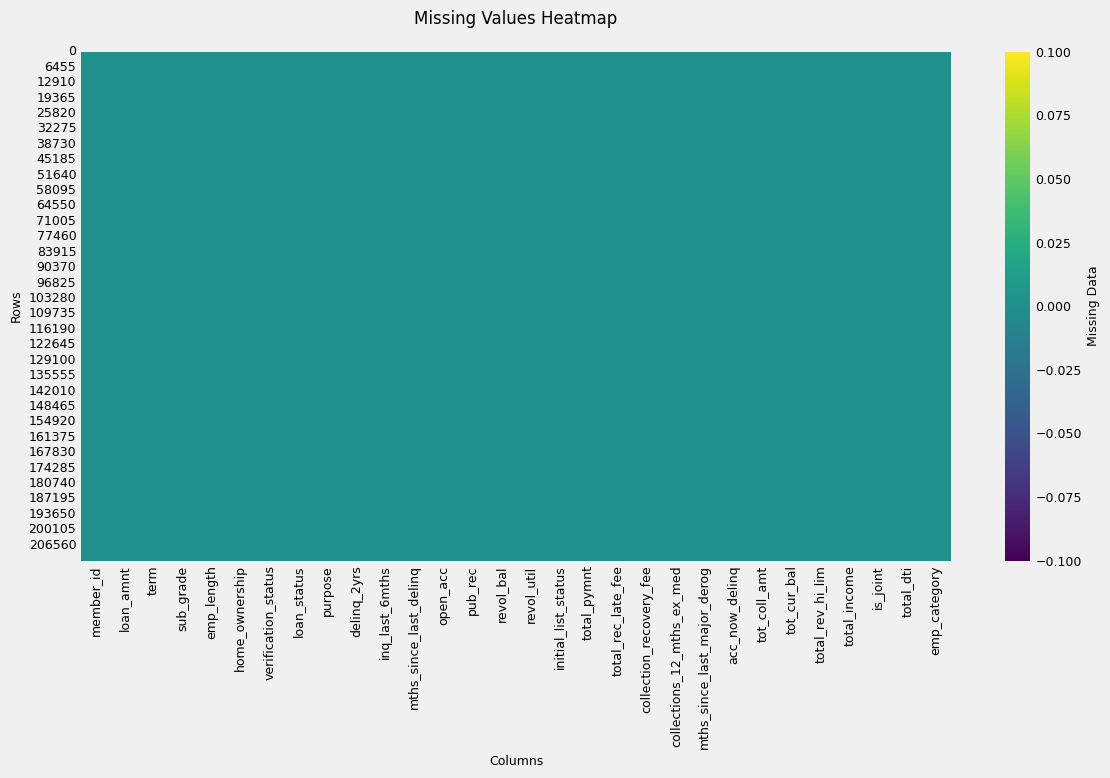

In [464]:
# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    null_mask,
    cbar_kws={'label': 'Missing Data'},
    cmap='viridis'
)
plt.title('Missing Values Heatmap', fontsize=12, pad=20)

# legend
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Missing Data', fontsize=9)

# labels
plt.xlabel('Columns', fontsize=9)
plt.ylabel('Rows', fontsize=9)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

Επομένως τα χαρακτηριστικά μειώθηκαν από 53 σε 31 και πλέον δεν έχω ελλείπουσες τιμές.

### *2.3.Εφαρμόστε όποια άλλη μέθοδο preprocessing θεωρείτε απαραίτητη*

#### Έκτοπες τιμές

Για την διαχείριση των έκτοπων τιμών, ας λάβουμε υπόψιν καταρχήν πως βάση στατιστικών, κατά μέσο όρο, σε 212999 πελάτες στην ΕΕ αναμένεται να έχουμε 3.56% * 212999 = 7582 μη εξυπηρετούμενα δάνεια. Αναζητούμε δηλαδή τις σπάνιες περιπτώσεις επί συνόλου του δείγματος, επομένως οι έκτοπες τιμές είναι πιο πιθανό να μας είναι πολύτιμες παρά να στρεβλώνουν το μοντέλο πρόβλεψής μας.

Μελετώντας τα περιγραφικά χαρακτηριστικά όλων των μεταβλητών στο Profiling Report, ξεχωρίζω τα εξής:

`dti` (Debt-to-Income Ratio): Από τη [βιβλιογραφία](https://www.navyfederal.org/makingcents/credit-debt/debt-to-income-ratio.html) διαβάζουμε πως ένας καλός δείκτης χρέους προς εισόδημα είναι 35% ή χαμηλότερος, αλλά κάποιος μπορεί να πληροί τις προϋποθέσεις για δάνειο με δείκτη DTI με ανώτατο όριο το 50%. Έχουμε 10 περιπτώσεις με τιμές του δείκτη πάνω από 100 δεν ευσταθούν λογικά, οπότε θα τις μεγιστοποιήσω έως 100:

In [465]:
df_raw.loc[df_raw['total_dti'] > 100, ['total_dti']] = 100

`pub_rec`: Βλέπω από το report πως οι καταγραφές οικονομικών υποχρεώσεων που αθετήθηκαν έχει λοξότητα 15.79, ενώ το 95ο εκατοστημόριο ή εκατοστιαία σηµεία (percentile) είναι 1, άρα τουλάχιστον το 95% των τιμών του είναι μονάδα. Στην ουρά της κατανομής βλέπω ακόμη πως έχω 10 τιμές όμως που κυμαίνονται από 15 έως και 86 καταγραφές. Από τη θεωρία γνωρίζω πως διατηρώντας τις ακραίες τιμές σε τέτοια επίπεδα: α) αυξάνεται ο μέσος όρος του χαρακτηριστικού β) αυξάνεται η διακύμανση γ) στρεβλώνεται την κανονικοποίηση των τιμών δ) επηρεάζονται τα βάρη των γραμμικών μοντέλων ε) οδηγούμαστε σε υπερπροσαρμογή. Επομένως θα τις θέσουμε με ένα ανώτατο όριο την τιμή 5:

In [466]:
df_raw.loc[df_raw['pub_rec'] > 5, ['pub_rec']] = 5

#### Τύποι Δεδομένων

*Η διαχείριση των κατηγορικών μεταβλητών*

Πολλά μοντέλα δεν μπορούν να διαχειριστούν κατηγορικά χαρακτηριστικά, όπως π.χ. η λογιστική παλινδρόμηση (παραμετρικό), τα νευρωνικά (παραμετρικά), Support Vector Machines (βασίζονται σε αποστάσεις σημείων σε χώρο n-διαστάσεων), K-Nearest Neighbours (αποστάσεις στον Ευκλείδιο χώρο) κ.ά. Σε αυτές τις περιπτώσεις, δεν μπορούμε να κωδικοποιήσουμε τις κλάσεις χρησιμοποιώντας αριθμούς, γιατί θα μετατρέπαμε τον τύπο τους από κατηγορικό σε διάταξης (ordinal), όπου η διάταξη των αριθμών θα μεταφραζόταν από το μοντέλο ως έχουσα κάποια σημασία (η κλάση Α (2) > της κλάσης Β (1) κλπ.), πράγμα που δεν ισχύει. Μπορούμε επομένως να κωδικοποιήσουμε τις κλάσεις των κατηγορικών μεταβλητών χρησιμοποιώντας μεθόδους όπως την one-hot encoding, όπου δημιουργούνται νέες στήλες (χαρακτηριστικά) με δυαδικές τιμές (1 ή 0) για την κάθε γραμμή δεδομένων, για κάθε χαρακτηριστικό.

Οι κατηγορικές μεταβλητές που έχω κρατήσει στο μοντέλο είναι:

`home_ownership`: παίρνει τις τιμές 'mortgage', 'rent', 'own' και 'any'. Το τελευταίο δίνεται μόνο σε 2 data points, που θα μου δημιουργούσαν μια εξαιρετικά αραιή στήλη - και άρα θα τα αφαιρέσω.



In [467]:
df_raw['home_ownership'].unique()

array(['OWN', 'MORTGAGE', 'RENT', 'ANY'], dtype=object)

In [468]:
df_raw.drop(df_raw[df_raw['home_ownership'] == 'ANY'].index, inplace=True)

In [469]:
df_raw['home_ownership'].unique()

array(['OWN', 'MORTGAGE', 'RENT'], dtype=object)

Για την ιδιοκτησία κατοικίας, θα κάνω 2 στήλες αντί για 3, για να αποφύγω κι εδώ την πολυσυγραμμικότητα (`drop_first=True`)

In [470]:
df_raw = pd.get_dummies(df_raw, prefix='home_ownership', prefix_sep='_', columns=['home_ownership'], drop_first=True)

`verification_status`: Παίρνει τρεις τιμές ('Source Verified', 'Verified' και 'Not Verified').

In [471]:
df_raw = pd.get_dummies(df_raw, prefix='verification', prefix_sep='_', columns=['verification_status'], drop_first=True)

`loan_status`: εάν το δάνειο εξυπηρετείται ή όχι. Με δεδομένο πως στο ερώτημα 2.4 (παρακάτω) η μεταβλητή στόχος είναι το αν θα λάβει κάποιος το δάνειο ή όχι, πρέπει να το αφαιρέσουμε, γιατί στο στάδιο των υποψηφιοτήτων για τα δάνεια, δεν γνωρίζουμε αυτό το χαρακτηριστικό (βλ. επεξήγηση για το data leakage στο ερώτημα 2.4).

`purpose`: ο σκοπός χρήσης του δανείου στην αίτηση. Φαίνεται ως σημαντικό χαρακτηριστικό και βλέπω στο Report πως περιγράφεται για το 93% των καταγραφών από 5 κλάσεις:

debt_consolidation (57.7%)

credit_card (25.5%)

home_improvement (6.3%)

major_purchase (1.9%)

medical (1.0%)

Θα δημιουργήσω μια στήλη για κάθε μία από αυτές τις κλάσεις με one-hot encoding, και τις λοιπές κλάσεις θα τις ενοποιήσω σε μια, με όνομα 'less_common_purpose'.

Ο λόγος είναι πως θέλω να αποφύγω τη δημιουργία αραιών (sparse) στηλών στο μοντέλο επειδή:

α) Αυξάνονται οι διαστάσεις του μοντέλου, οδηγώντας σε υπερπροσαρμογή για τις περιπτώσεις ύπαρξης της τιμής (του 1 δηλαδή) και υπολογιστικό κόστος.

β) Προκειμένου να καταγράψουν τις σπάνιες περιπτώσεις όπου έχουμε 1 αντί για 0, τα γραμμικά μοντέλα μπορεί να δώσουν μεγάλα βάρη σε αυτά τα χαρακτηριστικά οδηγώντας σε λάθη διασποράς (high variance errors).

In [472]:
# οι μοναδικές τιμές του χαρακτηριστικού
df_raw['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'major_purchase',
       'small_business', 'home_improvement', 'moving', 'other', 'car',
       'medical', 'house', 'vacation', 'renewable_energy', 'wedding'],
      dtype=object)

In [473]:
less_common_purpose = ['small_business', 'moving', 'car', 'other', 'house', 'vacation', 'renewable_energy', 'wedding']

In [474]:
df_raw['purpose_oht'] = df_raw['purpose'].where(
    ~df_raw['purpose'].isin(less_common_purpose),
    'less_common_purpose'
)

In [475]:
df_raw = pd.get_dummies(df_raw, columns=['purpose_oht'], prefix='purpose', drop_first=True)
# drop the inital column
df_raw = df_raw.drop('purpose', axis=1)

Ας εξετάσουμε το `term`:

In [476]:
df_raw['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

Στο πλαίσιο του one-hot encoding δεν θα δημιουργήσω δύο στήλες, γιατί - εφόσον η μια συμπληρώνει την άλλη - θα έχουν τέλεια πολυσυγγραμμικότητα. Η πολυσυγγραμμικότητα α) αυξάνει το μέγεθος των τυπικών σφαλμάτων των εκτιμητριών β) μειώνει την πιθανότητα οι εκτιμήσεις των συντελεστών να είναι στατιστικά σημαντικοί και γ) οδηγεί σε υπερπροσαρμογή στα δεδομένα εκπαίδευσης.

Άρα θα δημιουργήσω μια στήλη όπου με 1 θα δηλώνεται η 36μηνη διάρκεια του δανείου και με 0 θα εννοείται η 60μηνη:

In [477]:
df_raw['term_is_36'] = (df_raw['term'] == ' 36 months').astype(int)
# drop the inital column
df_raw.drop(columns='term', inplace = True)

Τέλος, κάνω one-hot encoding και για τα επαγγέλματα που ομαδοποίησα νωρίτερα:

In [478]:
df_raw = pd.get_dummies(df_raw, prefix='emp_category', prefix_sep='_', columns=['emp_category'], drop_first=True)

In [479]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212997 entries, 0 to 212998
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   member_id                     212997 non-null  int64  
 1   loan_amnt                     212997 non-null  int64  
 2   sub_grade                     212997 non-null  object 
 3   emp_length                    212997 non-null  int64  
 4   loan_status                   212997 non-null  object 
 5   delinq_2yrs                   212997 non-null  int64  
 6   inq_last_6mths                212997 non-null  int64  
 7   mths_since_last_delinq        212997 non-null  float64
 8   open_acc                      212997 non-null  int64  
 9   pub_rec                       212997 non-null  int64  
 10  revol_bal                     212997 non-null  int64  
 11  revol_util                    212997 non-null  float64
 12  initial_list_status           212997 non-null  ob

### *2.4. Έστω η τράπεζα αποφασίζει να χορηγήσει δάνεια στους Α, Β1, Β2 και ως target θεωρήσουμε αν κάποιος υποψήφιος θα λάβει δάνειο ή όχι (Δηλαδή αν θα βρίσκεται στις κατηγορίες Α, Β1 ή Β2) τι συμπεραίνετε για τα targets; Δημιουργήστε αντίστοιχη στήλη για τα targets.*

<!-- **Υπόθεση Εργασίας**

Η βάση δεδομένων περιέχει άτομα που ήδη έχουν λάβει κάποιο δάνειο. Επομένως υποθέτουμε πως η τράπεζα προγραμματίζει μια δεύτερη σειρά δανείων, τα οποία θα αποδόσει μόνο στους A, B1 και B2, και για την διαδικασία κατάταξης σε grades είναι γνωστά τα εξης:

- Η συμπεριφορά των δανειοληπτών στα υφιστάμενα δάνεια, δηλαδή τυχόν καθυστερήσεις ή αθέτηση πληρωμών. -->

Το πρώτο συμπέρασμα είναι πως έχουμε ένα πρόβλημα δυαδικής (binary) ταξινόμησης με:

- Κλάση 1: Subgrades A1, A2, A3, A4, A5, B1, B2
- Κλάση 0: Subgrades B3, B4, B5, C1-C5, D1-D5, E1-E5, F1-F5, G1-G5

Εφόσον έχουμε τα labels, ας δούμε την κατανομή τους:

In [480]:
print(f"{(len(df_raw[df_raw['sub_grade'].isin(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2'])])/len(df_raw)*100):.2f}")

28.78


Άρα το 28.8% των ετικετών είναι κλάσης 1 και το 71.2% είναι κλάσης 0 - πρόκειται για μερικώς άνιση κατανομή. Σε αυτές τις περιπτώσεις, η μετρική της Ακρίβειας (Accuracy) είναι επισφαλής, γιατί δεν λαμβάνει υπόψιν της την αρχική κατανομή θετικών και αρνητικών δειγμάτων. Μετρικές όπως η F-score (αρμονικός μέσος), που ενσωματώνει τόσο το την Ανάκληση (Recall) όσο και την Ευστοχία (Precision), μπορεί να είναι καταλληλότερες.

Παραδείγματος χάριν, εάν στην περίπτωσή μας έθετα όλες τις προβλέψεις y
ίσες με την τιμή της πολυπληθέστερης ομάδας ‘Κλάση 0’, θα είχα ακρίβεια 71.2% προβλέποντας σωστά μόνο τις περιπτώσεις της 'Κλάσης 0', χωρίς να προβλέψω ούτε μία περίπτωση της 'Κλάσης 1'. Σε αυτή την περίπτωση το μοντέλο δεν έχει κάποια προγνωστική αξία, και η ακρίβεια αυτή ονομάζεται `Baseline Accuracy`.

Επιπλέον, το να μην μπορεί να εξυπηρετηθεί ένα δάνειο σημαίνει πως χάνεται το αρχικό κεφάλαιο· το να μην δοθεί δάνειο σε έναν καλό πελάτη, σημαίνει πως χάνεται το κέρδος από τους τόκους, που εξ' ορισμού είναι μικρότεροι. Επομένως στο μοντέλο μας πρέπει να δώσουμε έμφαση στη μείωση των False Positives (που στην πραγματικότητα θα έπρεπε να ανήκουν στην 0, απόρριψη δανείου), και στη μετρική Precision.

**Data Leakage**

Εφόσον θέλουμε να δημιουργήσουμε ένα μοντέλο πρόβλεψης για την απονομή ή όχι ενός δανείου, στις εξαρτημένες μεταβλητες (χαρακτηριστικά) δεν θα πρέπει να συμπεριλαμβάνονται εκείνα τα οποία γίνονται γνωστά μετά την απονομή του δανείου και δεν είναι γνωστά κατά την στιγμή της αξιολόγησης του βαθμού δανειοληπτικής ικανότητας (πρόβλεψη). Αυτό ονομάζεται [data leakage](https://www.ibm.com/think/topics/data-leakage-machine-learning).

Τα χαρακτηριστικά αυτά (όσα δεν είχαν αφαιρεθεί από νωρίτερα στάδια) είναι τα παρακάτω:

`term_is_36`: η διάρκεια του δανείου που έχει λάβει κάποιος

`loan_status`: εάν εξυπηρετείται το δάνειο ή όχι

`total_pymnt`: το ποσό που έχει ληφθεί από την αποπληρωμή του δανείου

`total_rec_late_fee`: αργοπορημένες αποπληρωμές του δανείου

`collection_recovery_fee`: τα κόστη είσπραξης ληξιπρόθεσμων οφειλών

`initial_list_status`: Είναι η κατάσταση αρχικής καταχώρησης του δανείου (ολική ή μερική)

Οπότε τα αφαιρώ:

In [481]:
df_raw.drop([
    'term_is_36',
    'total_pymnt',
    'loan_status',
    'total_rec_late_fee',
    'collection_recovery_fee',
    'initial_list_status'
    ], axis=1, inplace=True)

In [482]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212997 entries, 0 to 212998
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   member_id                     212997 non-null  int64  
 1   loan_amnt                     212997 non-null  int64  
 2   sub_grade                     212997 non-null  object 
 3   emp_length                    212997 non-null  int64  
 4   delinq_2yrs                   212997 non-null  int64  
 5   inq_last_6mths                212997 non-null  int64  
 6   mths_since_last_delinq        212997 non-null  float64
 7   open_acc                      212997 non-null  int64  
 8   pub_rec                       212997 non-null  int64  
 9   revol_bal                     212997 non-null  int64  
 10  revol_util                    212997 non-null  float64
 11  collections_12_mths_ex_med    212997 non-null  int64  
 12  mths_since_last_major_derog   212997 non-null  fl

Ας δημιουργήσουμε την στήλη 'loan_approved' με βάση τα παραπάνω, όπου με 1 θα σημειώνονται τα subgrades [A1-A5, B1, B2] και με 0 τα υπόλοιπα:

In [483]:
approved_grades = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2']
df_raw['loan_approved'] = df_raw['sub_grade'].isin(approved_grades).astype(int)
# drop initial
df_raw.drop(columns=['sub_grade'], axis=1, inplace=True)

In [484]:
df_raw.head()

,member_id,loan_amnt,emp_length,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,...,emp_category_driver,emp_category_engineer,emp_category_manager,emp_category_officer,emp_category_other,emp_category_specialist,emp_category_supervisor,emp_category_teacher,emp_category_technician,loan_approved
0,64537751,20000,1,0,1,210.00,25,0,31578,77.00,...,False,False,False,False,True,False,False,False,False,0
1,64163931,11000,7,0,0,36.00,13,1,5084,38.80,...,False,False,False,False,True,False,False,False,False,0
2,64333218,7000,6,0,1,210.00,18,0,12070,74.00,...,False,False,False,False,True,False,False,False,False,0
3,63900496,10000,10,0,2,210.00,18,0,22950,66.00,...,False,False,True,False,False,False,False,False,False,0
4,62544456,9550,0,0,3,69.00,9,0,4172,29.60,...,False,False,False,False,True,False,False,False,False,0


### *2.5. Υπάρχει κάποιο αιτούμενο εύρος ποσού (πχ από 20000-25000) (loan_amnt) το οποίο να γίνει δεκτό για δανειοδότηση με πιθανότητα τουλάχιστον 15% από αυτούς που το αιτούνται; Αν Ναι, να βρείτε και να αναφέρετε με κατάλληλο τρόπο ένα τέτοιο εύρος.*

Αυτό που ζητείται είναι να δούμε την κατανομή της αναλογίας (loan_approved = 1 / loan_approved = 0) σε ομαδοποιήσεις (bins) του loan_amnt. Από το report ξέρω πως κυμαίνεται στο εύρος [1000, 35000]. Θα χρησιμοποιήσω τη μέθοδο `pd.cut` της pandas και ένα groupby για να βρω τις αναλογίες για κάθε bin:

In [485]:
df_raw['loan_category'] = pd.cut(df_raw['loan_amnt'], bins=7)

df_raw.groupby(by=['loan_category'], sort=True)[['loan_approved']].mean().rename(columns={'loan_approved': 'approval_ratio'})


/tmp/ipython-input-1726089593.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_raw.groupby(by=['loan_category'], sort=True)[['loan_approved']].mean().rename(columns={'loan_approved': 'approval_ratio'})


,approval_ratio
loan_category,
"(966.0, 5857.143]",0.25
"(5857.143, 10714.286]",0.35
"(10714.286, 15571.429]",0.29
"(15571.429, 20428.571]",0.28
"(20428.571, 25285.714]",0.29
"(25285.714, 30142.857]",0.28
"(30142.857, 35000.0]",0.13


Βλέπω λοιπόν πως με εξαίρεση ποσά άνω των περίπου 30000€, η πιθανότητα να γίνουν δεκτά τα δάνεια είναι άνω του 15% κατά μέσο όρο για όλες τις αιτήσεις και κατά προσέγγιση πιθανότητα 29-30%.

In [486]:
# and drop the additional column
df_raw.drop(columns='loan_category', axis=1, inplace=True)

### Ερώτημα 3 - Classification

#### *3.1. Να κανονικοποιήσετε (normalization) τις εισόδους με κατάλληλο τρόπο. Είστε ελεύθεροι να επιλέξετε μέθοδο, αλλά θα πρέπει να τη δικαιολογήσετε.*

#### *3.2. Να χωρίσετε κατάλληλα το dataset σε train, test sets σε (70-30). Χρησιμοποιείστε τη μέθοδο Stratify για τον διαχωρισμό.*

Η επιλογή της μεθόδου κανονικοποίησης εξαρτάται τόσο από τα χαρακτηριστικά των δεδομένων, όσο και από το μοντέλο μηχανικής μάθησης που σκοπεύουμε να εφαρμόσουμε:

**Χαρακτηριστικά των δεδομένων**

Από τα διαγράμματα κατανομής του report παρατηρώ πως ορισμένα χαρακτηριστικά έχουν μεγάλη (δεξιά) λοξότητα στην κατανομή τους, όπως τα `annual_inc`, `dti`, `delinq_2yrs`, `open_acc`, `revol_bal`, `total_acc`, `total_rev_hi_lim`. Σε αυτές τις περιπτώσεις, η εφαρμογή κανονικοποίησης ελαχίστου-μεγίστου θα συγκέντρωνε τη μεγάλη πλειοψηφία των τιμών σε ένα ελάχιστο τμήμα της περιοχής τιμών και θα χρησιμοποιούσε το υπόλοιπο τμήμα της περιοχής για τις
εξαιρέσεις (outliers), άρα δεν είναι κατάλληλη.

Στην κανονικοποίηση z-score, διαιρώ την διαφορά της εκάστοτε τιμής με την τυπική απόκλιση της μεταβλητής. Σαν αποτέλεσμα, τα χαρακτηριστικά αποκτούν όλα μέση τιμή ίση με το 0 και με διακυμάνσεις παρόμοιας κλίμακας, εξαλείφοντας έτσι την επίδραση μεγάλων διακυμάνσεων στο μοντέλο μάθησης.

**Μοντέλο Μάθησης**

Ένας επιπλέον λόγος για τον οποίο επιλέγουμε να κανονικοποιήσουμε τις εισόδους (χαρακτηριστικά) είναι ώστε να αντιμετωπιστούν δυσκολίες ορισμένων μεθόδων μάθησης. Για παράδειγμα, τα Νευρωνικά Δίκτυα λειτουργούν καλύτερα όταν οι τιμές εισόδου κυμαίνονται στην περιοχή [0,1] ενώ άλλα μοντέλα πρόβλεψης (π.χ. k-NN) χρησιμοποιούν τις αποστάσεις στον Ευκλείδιο χώρο για να εκτιμήσουν τη συσχέτιση εξαρτημένων και ανεξάρτητων μεταβλητών.  Το πρόβλημα συνίσταται στο γεγονός ότι οι μεταβλητές με τις μεγάλες τιμές καθορίζουν ουσιαστικά την απόσταση των παρατηρήσεων, ενώ οι μεταβλητές με τις μικρές τιμές επηρεάζουν την απόσταση ελάχιστα και τελικά, δεν παίζουν κανένα ρόλο στον υπολογισμό του αποτελέσματος.

Αντίθετα, μοντέλα όπως τα Δένδρα Απόφασης χρησιμοποιούν λογικούς ελέγχους για να εξάγουν κανόνες, οπότε δεν επηρεάζονται από τις κλίμακες των χαρακτηριστικών.


**Διαχωρισμός σε training και test set**

Μιας και - όπως είδαμε νωρίτερα - οι κλάσεις της μεταβλητής-στόχου δεν είναι ισορροπημένες, θα χρησιμοποιήσουμε τη μέθοδο της διαστρωματωμένης παρακράτησης στον διαχωρισμό των δεδομένων εκπαίδεσης και test, ώστε κάθε κλάση να αντιπροσωπεύεται από το ίδιο ποσοστό δεδομένων:

In [487]:
# γενική ρύθμιση για την εμφάνιση δεκαδικών στην pandas
pd.set_option('display.float_format', '{:.2f}'.format)

In [488]:
# το member id το έχω κρατήσει μόνο για την ταυτοποίηση των υποψήφιων δανειοληπτών
X = df_raw.drop(['loan_approved', 'member_id'], axis=1)
y = df_raw['loan_approved']

In [489]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    random_state=5,
    # stratify ώστε να έχω ισότιμο διαχωρισμό των κλάσεων
    stratify=y,
    test_size=0.30
    )

**Κανονικοποίηση**

Για την κανονικοποίηση z-score Θα χρησιμοποιήσουμε τη μέθοδο StandardScaler της scikit learn γιατί, με βάση τα όσα είπαμε παραπάνω, [χρησιμοποιεί το z-score](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) για να την πραγματοποιήσει:

In [490]:
# κανονικοποίηση
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert to df
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


#### *3.3. Εφαρμόστε κατάλληλο classifier για την πρόβλεψη της δανειοδότησης ενός υποψηφίου. Μπορείτε να χρησιμοποιήσετε όποιο μοντέλο θέλετε, αρκεί να δικαιολογήσετε την επιλογή του.*

Σύμφωνα με την [Οδηγία 2023/2225 της ΕΕ](https://eur-lex.europa.eu/legal-content/EL/TXT/HTML/?uri=OJ:L_202302225) *«Όταν αίτηση πίστωσης απορρίπτεται βάσει έρευνας σε βάση δεδομένων, οι πιστωτικοί φορείς θα πρέπει να ενημερώνουν τους καταναλωτές χωρίς αδικαιολόγητη καθυστέρηση και δωρεάν για το αποτέλεσμα της εν λόγω έρευνας και τα στοιχεία της συγκεκριμένης βάσης δεδομένων, καθώς και για τις κατηγορίες δεδομένων που ελήφθησαν υπόψη»*. Αυτό σημαίνει πως το μοντέλο ταξινόμησης που θα επιλέξω πρέπει να είναι ερμηνεύσιμο, επομένως κάποιες επιλογές είναι:

- Λογιστική παλινδρόμηση
- Δένδρο απόφασης
- Μοντέλα Explainable AI, όπως το SHapley Additive exPlanations

**Λογιστική Παλινδρόμηση**

Θα ξεκινήσω με Λογιστική παλινδρόμηση. Από το documentation της, μπορούμε να χρησιμοποιήσουμε `class_weight='balanced' ως παράμετρο, για να προσαρμόσουμε τα βάρη της μεταβλητής στόχου` (`y`) αντιστρόφως ανάλογα των συχνοτήτων των κλάσεών της:

In [491]:
logistic_classifier = LogisticRegression(max_iter=10000, random_state=5, class_weight='balanced')
logistic_classifier.fit(X_train_scaled, y_train)

# οι προβλέψεις της λογιστικής παλινδρόμησης
y_pred_logistic = logistic_classifier.predict(X_test_scaled)

acc_lg = accuracy_score(y_test, y_pred_logistic) * 100
print(f"Logistic Regression model accuracy: {acc_lg:.2f}%")

Logistic Regression model accuracy: 73.84%


Το αποτέλεσμα είναι μάλλον απογοητευτικό, καθώς - όπως είδαμε παραπάνω - εάν προέβλεπα όλες τις τιμές του y ως rejected (0), θα λάμβανα ακρίβεια 71.20%. Το μοντέλο δηλαδή βελτιώνει την πρόβλεψη μόνο κατά 2.83% σε σχέση με το να προβλέπαμε απλά πάντα "Δεν εγκρίθηκε".


In [492]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

Η scikit learn πλέον μας δίνει και έναν εύκολο τρόπο να δούμε τον πίνακα σύγχυσης:

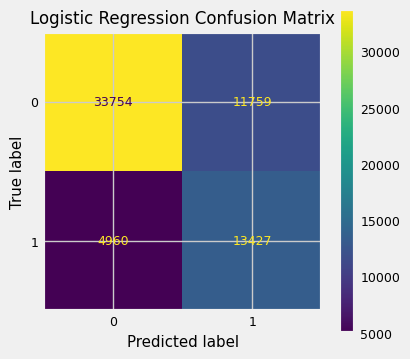

In [493]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(figsize=(4, 4))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_logistic,
    display_labels=logistic_classifier.classes_
)

ax.set_title('Logistic Regression Confusion Matrix', fontsize=12)

disp.plot(ax=ax)
plt.show()

Επιπλέον πρέπει να εστιάσω στη μείωση των False Positives, που όπως προείπαμε συνεπάγονται μεγάλο κόστος για την τράπεζα και άρα στη μετρική Precision:

In [494]:
precision_logistic = precision_score(y_test, y_pred_logistic, pos_label=1)
print(f"Precision for logistic regression is: {precision_logistic:.2f}")

Precision for logistic regression is: 0.53


Το αποτέλεσμα δείχνει πως `True Positives / (True Positives + False Positives)` = 54% των προβλέψεων για έγκριση του υποψηφίου ήταν λάθος (FP), άρα δεν είναι αποδεκτό - το 46% αυτών που εγκρίνονται, δεν έχουν αξιολόγηση Α, Β1 ή Β2!

**Δένδρα Απόφασης**

Ας δοκιμάσουμε προβλέψεις και με δέντρα απόφασης:

In [495]:
decision_tree_classifier = DecisionTreeClassifier(random_state=5, class_weight='balanced')

decision_tree_classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=5)

In [496]:
# οι προβλέψεις των δένδρων απόφασης
y_pred_decision_tree = decision_tree_classifier.predict(X_test_scaled)

acc_dt = accuracy_score(y_test, y_pred_decision_tree) * 100
print(f"Decision Tree model accuracy: {acc_dt:.2f}%")

Decision Tree model accuracy: 70.71%


In [497]:
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, pos_label=1)
print(f"Precision for Decision Tree is: {precision_decision_tree:.2f}")

Precision for Decision Tree is: 0.49


Το Δένδρο Απόφασης δεν μας προσφέρει καμία γνώση στην πρόβλεψή μας, έχοντας ακρίβεια 70.95% (δηλαδή λίγο χειρότερα από το baseline μας) και ευστοχία (precision) 50% - μια στις δύο εγκρίσεις για δάνειο είναι λανθασμένη.

#### *Επιπλέον, αν θέλετε, μπορείτε να εφαρμόσετε cross-validation στο train set για την εύρεση κατάλληλων παραμέτρων του μοντέλου σας. Επειδή το dataset είναι μεγάλο, επιλέξτε μόνο την πιο ευαίσθητη παράμετρο (προαιρετικά).*

Θα εφαρμόσω nested cross-validation, μια τεχνική για τη βελτιστοποίηση των υπερπαραμέτρων του μοντέλου, που στόχο έχει την αντιμετώπιση της υπερπροσαρμογής στα δεδομένα εκπαίδευσης. Την ονομάζουμε «ένθετη» γιατί λαμβάνει χώρα μέσα στο πλαίσιο της k-fold διασταυρούμενης επικύρωσης, που σε άλλες περιπτώσεις εφαρμόζεται όταν ο όγκος των δεδομένων μας είναι περιορισμένος.

Επομένως, θα χωρίσω κι εδώ τα δεδομένα σε k υποσύνολα ίσου μεγέθους, κρατώντας ένα υποσύνολο για τη δοκιμή του μοντέλου (test set) και τα υπόλοιπα k-1 υποσύνολα για την εκπαίδευσή του.

Στη συνέχεια, θα εφαρμόσω την τεχνική της τυχαίας αναζήτησης (RandomizedSearchCV) σε κάθε σύνολο δεδομένων εκπαίδευσης, για να βρω ένα βέλτιστο σύνολο υπερπαραμέτρων για το μοντέλο. Με αυτόν τον τρόπο, η αναζήτηση υπερπαραμέτρων δεν υπερπροσαρμόζεται στο σύνολο δεδομένων, καθώς εκτίθεται μόνο σε ένα υποσύνολό του κάθε φορά.

In [498]:
# parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# χρησιμοποιώ τον decision_tree_classifier που δημιούργησα νωρίτερα

# instantiate
random_search = RandomizedSearchCV(estimator=decision_tree_classifier,
    param_distributions=param_grid,
    # number of combinations
    n_iter=50,
    verbose=0,
    # 5-fold, stratified
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=5),
    random_state=5,
    # scoring όχι με accuracy (λόγω imbalanced set)
    scoring='roc_auc',
    # use all processors
    n_jobs=-1)

# fit
random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=5),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=5, scoring='roc_auc')

In [499]:
# Οι καλύτερες παράμετροι
print(f"The best parameters are: {random_search.best_params_}")

# get predictions
y_pred_cv_search = random_search.predict(X_test_scaled)
y_pred_proba_cv_search = random_search.predict_proba(X_test_scaled)[:, 1]

The best parameters are: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}


#### *Αναφέρετε την ακρίβεια, F1, Precision, Recall για το καλύτερο μοντέλο του validation set. Ποιες μετρικές είναι πιο σημαντικές για αυτή την εφαρμογή;*

In [500]:
acc_cv_search = accuracy_score(y_test, y_pred_cv_search) * 100
f1_cv_search = f1_score(y_test, y_pred_cv_search, pos_label=1)
precision_cv_search = precision_score(y_test, y_pred_cv_search, pos_label=1)
recall_cv_search = recall_score(y_test, y_pred_cv_search, pos_label=1)
roc_auc_cv_search = roc_auc_score(y_test, y_pred_proba_cv_search)

print(f"Randomized Search Accuracy is:  {acc_cv_search:.2f}%")
print(f"Randomized Search Precision is: {precision_cv_search:.2f}")
print(f"Randomized Search Recall is:    {recall_cv_search:.2f}")
print(f"Randomized Search F1-Score is:  {f1_cv_search:.2f}")
print(f"Randomized Search ROC-AUC is:   {roc_auc_cv_search:.4f}")

Randomized Search Accuracy is:  70.89%
Randomized Search Precision is: 0.50
Randomized Search Recall is:    0.75
Randomized Search F1-Score is:  0.60
Randomized Search ROC-AUC is:   0.7933


Ακόμα και με την εφαρμογή cross-validation για την εύρεση των υπερπαραμέτρων του μοντέλου, το μοντέλο δεν προσφέρει καμία προγνωστική ικανότητα.

Όπως αναφέραμε και στο κεφάλαιο 2.4, το να μην μπορεί να εξυπηρετηθεί ένα δάνειο σημαίνει πως χάνεται το αρχικό κεφάλαιο της τράπεζας, ενώ το να μην δοθεί δάνειο σε έναν καλό πελάτη, σημαίνει πως χάνεται το κέρδος από τους τόκους, που εξ' ορισμού είναι μικρότεροι. Επομένως στο μοντέλο μας πρέπει να δώσουμε έμφαση στη μείωση των False Positives (που στην πραγματικότητα θα έπρεπε να ανήκουν στην 0, απόρριψη δανείου), και στις μετρικές F1-score και κυρίως στην Precision (TP / (TP + FP)).

### Ερώτημα 4 (Feature Importance & Selection)
#### *4.1.	Εκπαιδεύστε ταξινομητή Random Forest (εφόσον εφαρμόσετε κανονικοποίηση και διαχωρισμό σε train/test) και αναφέρετε τα 15 σημαντικότερα χαρακτηριστικά στη πρόβλεψη δανειοδότησης.*



In [501]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=5, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# get predictions
y_pred_random_forest = rf_model.predict(X_test_scaled)
y_pred_proba_random_forest = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_random_forest):.2f}")

Random Forest Accuracy: 0.79


In [502]:
precision_random_forest = precision_score(y_test, y_pred_random_forest, pos_label=1)
print(f"Precision for Random Forest is: {precision_random_forest:.2f}")

Precision for Random Forest is: 0.72


Με τον αλγόριθμο του τυχαίου δάσους αυξάνεται η ακρίβεια και ιδιαίτερα η ευστοχία (από 54% στη Λογιστική Παλινδρόμηση σε 73%), χάνουμε όμως την ερμηνευσιμότητα που είχαμε θέσει ως προαπαιτούμενο για μια τέτοια εργασία.

Για τα 15 σημαντικότερα χαρακτηριστικά έχουμε:

In [503]:
importances = rf_model.feature_importances_

feature_importances = pd.Series(importances, index=X_train_scaled.columns)

top_15_features_rf = feature_importances.sort_values(ascending=False).head(15)

print("Τα 15 σημαντικότερα χαρακτηριστικά είναι:\n")
print(top_15_features_rf.to_string())

Τα 15 σημαντικότερα χαρακτηριστικά είναι:

total_rev_hi_lim              0.11
revol_util                    0.11
total_dti                     0.10
loan_amnt                     0.09
total_income                  0.08
revol_bal                     0.07
tot_cur_bal                   0.07
open_acc                      0.05
inq_last_6mths                0.04
mths_since_last_delinq        0.04
verification_Verified         0.03
emp_length                    0.03
mths_since_last_major_derog   0.02
tot_coll_amt                  0.02
purpose_debt_consolidation    0.02


Άρα τα σημαντικότερα χαρακτηριστικά είναι το συνολικό διαθέσιμο πιστωτικό όριο του ατόμου (`total_rev_hi_lim`), το ποσοστό (%) του διαθέσιμου πιστωτικού ορίου που έχει χρησιμοποιηθεί (`revol_util`), το ποσό από το μηνιαίο εισόδημα του ατόμου πηγαίνει στην εξυπηρέτηση των μηνιαίων υποχρεώσεών του (`total_dti`), το ύψος του δανείου, το συνολικό εισόδημα κ.ά.

In [504]:
top_15_features_rf.index

Index(['total_rev_hi_lim', 'revol_util', 'total_dti', 'loan_amnt',
       'total_income', 'revol_bal', 'tot_cur_bal', 'open_acc',
       'inq_last_6mths', 'mths_since_last_delinq', 'verification_Verified',
       'emp_length', 'mths_since_last_major_derog', 'tot_coll_amt',
       'purpose_debt_consolidation'],
      dtype='object')

#### *4.2.	Τυπώστε το correlation matrix για αυτά τα χαρακτηριστικά. Υπάρχει correlation μεταξύ των χαρακτηριστικών αυτών;*

Για να πάρω τη συσχέτιση μεταξύ των 15 σημαντικότερων χαρακτηριστικών θα χρησιμοποιήσω τη μέθοδο `corr()` της pandas:


In [505]:
correlation_matrix = df_raw[top_15_features_rf.index].corr().round(2)

# print(correlation_matrix)

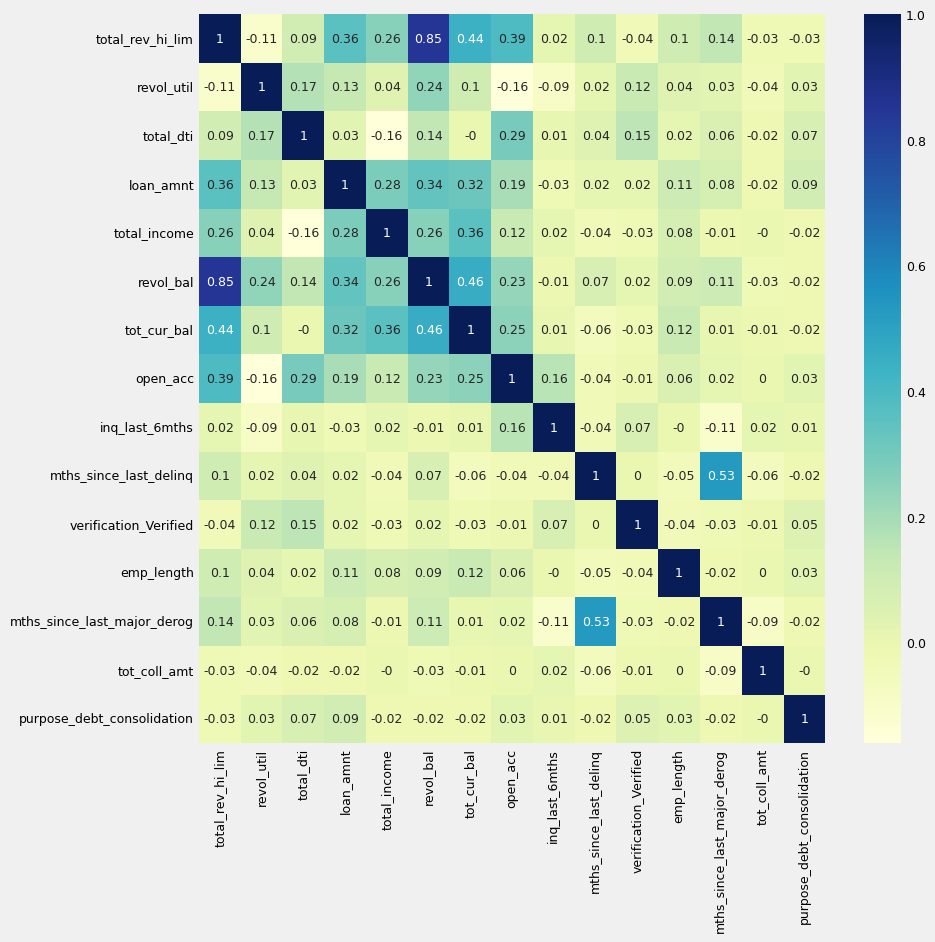

In [506]:
# set the dimensions
fig, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(correlation_matrix, cmap="YlGnBu", annot_kws={'fontsize': 9}, annot=True)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

Βλέπω πως την υψηλότερη συσχέτιση μεταξύ τους έχουν τα παρακάτω χαρακτηριστικά:

- `total_rev_hi_lim` και `revol_bal`:	0.85

- `total_acc` και `open_acc`: 0.71

#### *4.3.	Κρατήστε κάποια χαρακτηριστικά που να έχουν χαμηλό correlation μεταξύ τους και Επαναλάβετε το ερώτημα 4.1.*

Βλέποντας το διάγραμμα, τα χαρακτηριστικά που έχουν γενικά χαμηλή συσχέτιση μεταξύ τους είναι τα παρακάτω:

- `inq_last_6mths`

- `purpose_debt_consolidation`

- `mths_since_last_delinq`

- `emp_length`

- `verification_Verified`

- `total_dti`

- `revol_util`

- `total_income`

- `loan_amnt`

- `tot_coll_amt`

Επομένως τα συγκεντρώνω σε μια λίστα:

In [507]:
selected_features = [
    'inq_last_6mths',
    'purpose_debt_consolidation',
    'mths_since_last_delinq',
    'emp_length',
    'total_dti',
    'revol_util',
    'verification_Verified',
    'total_income',
    'loan_amnt',
    'tot_coll_amt'
]

Επαναλαμβάνω τον διαχωρισμό training και test:

In [508]:
# το νέο X matrix
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=5, stratify=y
)

Κανονικοποίηση:

In [509]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Και εκπαιδεύω εκ νέου το μοντέλο:

In [510]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=5,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=5)

In [511]:
# get predictions
y_pred_random_forest = rf_model.predict(X_test_scaled)
y_pred_proba_random_forest = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_random_forest):.2f}")

Random Forest Accuracy: 0.76


In [512]:
precision_random_forest = precision_score(y_test, y_pred_random_forest, pos_label=1)
print(f"Precision for Random Forest is: {precision_random_forest:.2f}")

Precision for Random Forest is: 0.63


Άρα με την αφαίρεση των χαρακτηριστικών με υψηλή συσχέτιση μεταξύ τους, χάθηκε και κάποια πληροφορία, καθώς η ευστοχία μειώθηκε κατά 0.03 (0.79 -> 0.76) ενώ η ακρίβεια κατά 0.10 (από 0.72 σε 0.62).

### Ερώτημα 5 - Dimensionality Reduction

#### *5.1. Φορτώστε το dataset των ασπρόμαυρων ψηφίων MNIST (της προηγούμενης άσκησης).*

In [513]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [514]:
print(f"Διαστάσεις: {x_train.shape}")

Διαστάσεις: (60000, 28, 28)


Άρα έχω έναν τανυστή με 3 διαστάσεις: 60000 σημεία,
28 x και 28 y.

#### *5.2. Εφαρμόστε τη μέθοδο Standard Scaling στα δεδομένα*

Για να εφαρμόσω standard scaling πρέπει να μετατρέψω τα δεδομένα μου σε διανύσματα (μια διάσταση):

In [515]:
X_train_flattened = x_train.reshape(x_train.shape[0], -1)
X_test_flattened = x_test.reshape(x_test.shape[0], -1)

In [516]:
print(f"Διαστάσεις μετά το flatten: {X_train_flattened.shape}")

Διαστάσεις μετά το flatten: (60000, 784)


Οπότε πλέον έχω μόνο δύο διαστάσεις (επιπεδότητα). Και κανονικοποιώ, όμοια με πριν:

In [517]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

#### *5.3. Εφαρμόστε PCA, ώστε να μειώσετε τα χαρακτηριστικά σε 300. Στη συνέχεια, εκπαιδεύστε ταξινομητή KNN με k=5,15,51, 101. Προσοχή: Θέλουμε να καλέσουμε την pca.fit_transform για το train set, αλλά μόνο τη συνάρτηση pca.transform για το test set.*

In [518]:
# θέτω τα χαρακτηριστικά σε 300
pca = PCA(n_components=300)
x_train_pca = pca.fit_transform(X_train_scaled)
x_test_pca = pca.transform(X_test_scaled)

In [519]:
ks = [5, 15, 51, 101]
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)
    y_pred = knn.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"K={k}: Accuracy = {acc:.4f}")

K=5: Accuracy = 0.9497
K=15: Accuracy = 0.9436
K=51: Accuracy = 0.9273
K=101: Accuracy = 0.9158


#### *Να αιτιολογήσετε τι θα γινόταν αν εφαρμόζαμε την fit transform στα x_train και x_test ξεχωριστά, ή σε όλα μαζί (δηλαδή αν ενώναμε τα x_train, x_test και εφαρμόζαμε pca) και υπολογίστε την ακρίβεια του ταξινομητή για κάθε k.*

Όπου `fit` και `transform` σύμφωνα με το [documentation](https://scikit-learn.org/stable/glossary.html#term-fit) επιτελούν τα εξής:

- `fit`: Παίρνει τα δεδομένα εισόδου και εξόδου, ελέγχει την εγκυρότητά τους και αποθηκεύει τις παραμέτρους του μοντέλου που πρόκειται να χτίσουμε, βάση των οποίων θα γίνουν οι προβλέψεις (εν προκειμένω τους Principal Components). Επιστρέφει έναν προσαρμοσμένο εκτιμητή.
- `transform`: Μεταμορφώνει τα δεδομένα εισόδου σε έναν νέο χώρο. Επιστρέφει διάνυσμα ή μητρώο μήκους όσα τα δείγματα, και με στήλες τις παραμέτρους που παίρνει από το fit. Η εφαρμογή του στο test set έχει δηλαδή στόχο να τα φέρει σε τέτοιο σύστημα αξόνων που θα επιτρέψει στο μοντέλο να τα χρησιμοποιήσει.

Επομένως:

α) Εάν εφαρμόζαμε την `fit_transform` και στα δύο set ξεχωριστά, θα είχαμε δύο διαφορετικούς χώρους δεδομένων, που δεν θα συμφωνούσαν μεταξύ τους. Το μοντέλο δεν θα μπορούσε να πάρει εισόδους από το test, γιατί δεν θα ήταν συμβατά με αυτό.

β) Εάν εφαρμόζαμε την `fit_transform` σε όλα τα δεδομένα θα παίρναμε παραμέτρους προσαρμοσμένες και στα δύο. Όταν θα δίναμε εν συνεχεία τα δεδομένα εισόδου test στο μοντέλο, θα είχε ήδη εκπαιδευθεί σε αυτά και θα έδινε εξόδους με μεγάλη ακρίβεια (είναι το data leakage που είδαμε και παραπάνω). Εμείς όμως θέλουμε να εκπαιδεύσουμε ένα μοντέλο με την ικανότητα να κάνει προβλέψεις σε άγνωστα δεδομένα, άρα δεν θα μας ήταν χρήσιμο.

#### *5.4. Εφαρμόστε LDA μειώνοντας τα χαρακτηριστικά σε 2 (lda.fit_transform στο x_train και lda.transform στο test). Στη συνέχεια: Να δημιουργήσετε 2D scatter plot με τα x_train ύστερα από σχηματισμό LDA. Δώστε διαφορετικό χρώμα σε κάθε ψηφίο. Τι παρατηρείτε για τον διαχωρισμό τους;*

In [520]:
# μειώνω τα χαρακτηριστικά
lda = LinearDiscriminantAnalysis(n_components=2)
x_train_lda = lda.fit_transform(X_train_scaled, y_train)
x_test_lda = lda.transform(X_test_scaled)

In [521]:
x_train_lda.shape

(60000, 2)

Άρα οι είσοδοί μου έχουν μετατραπεί σε πίνακα 2 διαστάσεων. Δημιουργώ το scatter plot:

/tmp/ipython-input-2916797080.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_train_lda[idx, 0], x_train_lda[idx, 1], label=str(digit), alpha=0.6, marker=".", s=3, c=color)


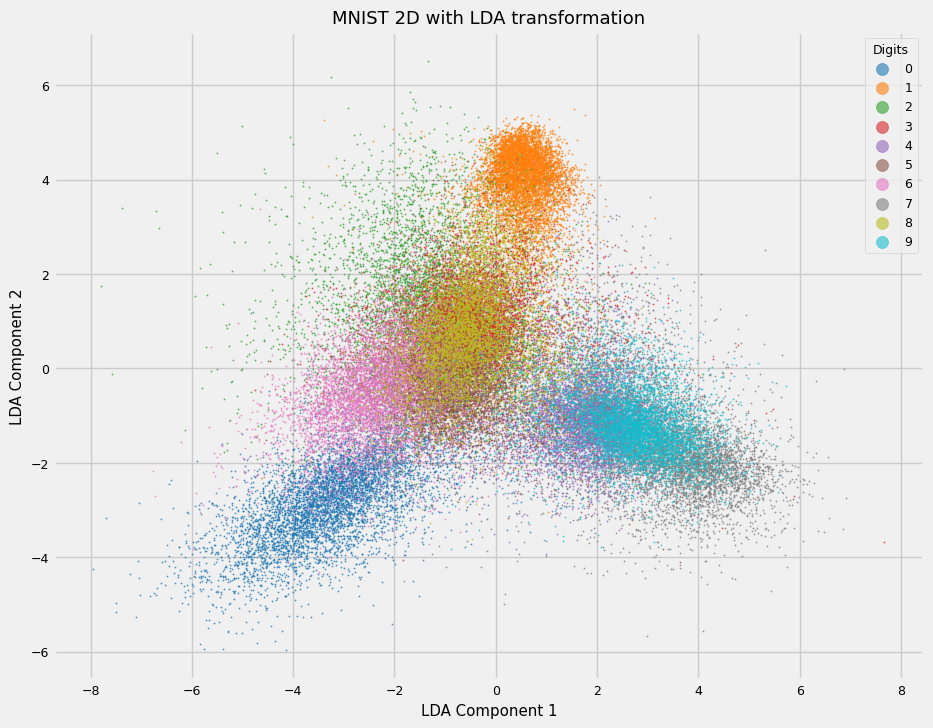

In [522]:
plt.figure(figsize=(10,8))
for digit in np.unique(y_train):
    color = sns.color_palette("tab10")[digit]
    idx = np.where(y_train == digit)
    plt.scatter(x_train_lda[idx, 0], x_train_lda[idx, 1], label=str(digit), alpha=0.6, marker=".", s=3, c=color)

plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("MNIST 2D with LDA transformation")
plt.legend(markerscale=10, title="Digits")
plt.show()


Από το διάγραμμα παρατηρώ τα εξής:

- Τα 0, 1 και 6 είναι εύκολα διαχωρίσιμα
- Το 4, 5 και 9 δεν διαχωρίζονται εύκολα μεταξύ τους
- Τα 3 και 8 παρομοίως

#### *5.5. Επαναλάβετε το ερώτημα 4, χρησιμοποιώντας τη βιβλιοθήκη umap: https://umap-learn.readthedocs.io/en/latest/ (ενδεχομένως να χρειαστεί εγκατάσταση στο colab: !pip install umap-learn). Να συγκρίνετε το διαχωρισμό της μεθόδου U-MAP με τον αντίστοιχο της LDA.*

In [523]:
!pip install umap-learn -q
import umap

In [524]:
reducer = umap.UMAP()

Παίρνω τις ήδη κανονικοποιημένες εισόδους μου `X_train_scaled`:

In [525]:
embedding = reducer.fit_transform(X_train_scaled)

In [526]:
embedding.shape

(60000, 2)

Βλέπουμε πως - όμοια με την LCA - και η UMAP μου δίνει έναν πίνακα 2 διαστάσεων. Μπορούμε επομένως να περάσουμε τα δεδομένα σε ένα scatter plot:

/tmp/ipython-input-1220410521.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[idx, 0], embedding[idx, 1], label=str(digit), alpha=0.6, marker=".", s=3, c=color)


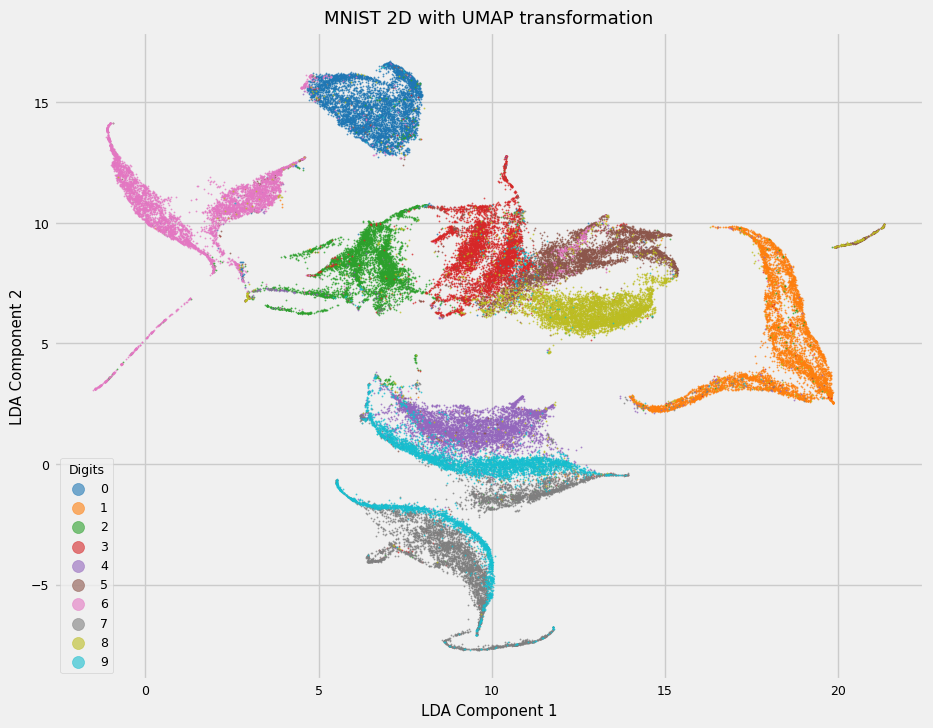

In [527]:
plt.figure(figsize=(10,8))
for digit in np.unique(y_train):
    color = sns.color_palette("tab10")[digit]
    idx = np.where(y_train == digit)
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=str(digit), alpha=0.6, marker=".", s=3, c=color)

plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("MNIST 2D with UMAP transformation")
plt.legend(markerscale=10, title="Digits")
plt.show()

Βλέπουμε πως η διαφορά είναι μεγάλη! Η UMAP χρησιμοποιώντας άλλον αλγόριθμο καταφέρνει και διαχωρίζει τα ψηφία σχεδόν τέλεια.